In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
%matplotlib inline

In [3]:
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

(244768, 12)

In [4]:
data.head()

Id                                              Title  \
0  12612628                        Engineering Systems Analyst   
1  12612830                            Stress Engineer Glasgow   
2  12612844                   Modelling and simulation analyst   
3  12613049  Engineering Systems Analyst / Mathematical Mod...   
4  12613647         Pioneer, Miser Engineering Systems Analyst   

                                     FullDescription  \
0  Engineering Systems Analyst Dorking Surrey Sal...   
1  Stress Engineer Glasgow Salary **** to **** We...   
2  Mathematical Modeller / Simulation Analyst / O...   
3  Engineering Systems Analyst / Mathematical Mod...   
4  Pioneer, Miser  Engineering Systems Analyst Do...   

                         LocationRaw LocationNormalized ContractType  \
0            Dorking, Surrey, Surrey            Dorking          NaN   
1        Glasgow, Scotland, Scotland            Glasgow          NaN   
2  Hampshire, South East, South East          Hampshire          NaN   
3     Surrey, South East, South East             Surrey          NaN   
4     Surrey, South East, South East             Surrey          NaN   

  ContractTime                       Company          Category  \
0    permanent  Gregory Martin International  Engineering Jobs   
1    permanent  Gregory Martin International  Engineering Jobs   
2    permanent  Gregory Martin International  Engineering Jobs   
3    permanent  Gregory Martin International  Engineering Jobs   
4    permanent  Gregory Martin International  Engineering Jobs   

                                SalaryRaw  SalaryNormalized        SourceName  
0              20000 - 30000/annum 20-30K             25000  cv-library.co.uk  
1              25000 - 35000/annum 25-35K             30000  cv-library.co.uk  
2              20000 - 40000/annum 20-40K             30000  cv-library.co.uk  
3  25000 - 30000/annum 25K-30K negotiable             27500  cv-library.co.uk  
4              20000 - 30000/annum 20-30K             25000  cv-library.co.uk

<Axes: >

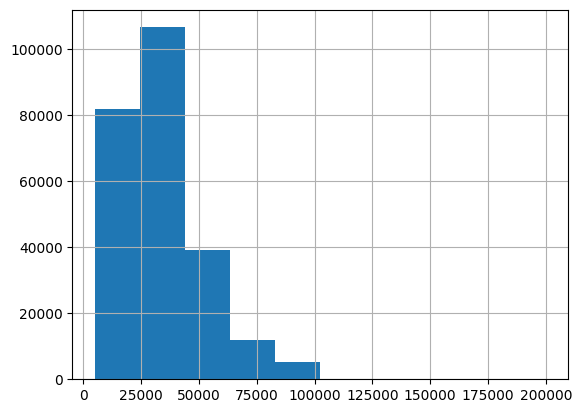

In [5]:
data['SalaryNormalized'].hist()

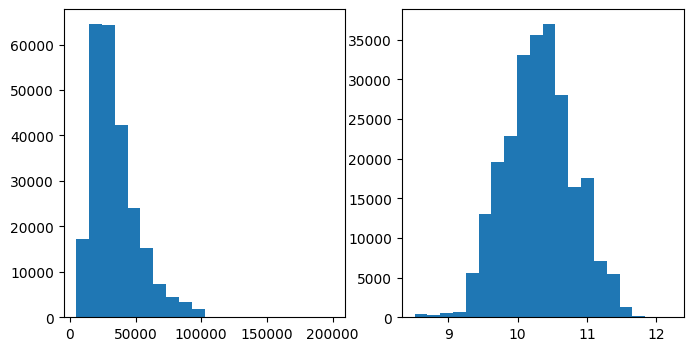

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

Id                                              Title  \
34727   68218655                         Electrical Design Engineer   
224796  72428277                              Landfill Site Manager   
28333   67948675  Sharepoint Developer  Leeds  **** , ****  ****...   

                                          FullDescription      LocationRaw  \
34727   My client are manufacturers of high quality Lo...       Derbyshire   
224796  My client s business centers on collection, re...  Buckinghamshire   
28333   My client a leader in the collection, handling...            Leeds   

       LocationNormalized ContractType ContractTime          Company  \
34727          Derbyshire          NaN    permanent  ESB Recruitment   
224796    Buckinghamshire          NaN    permanent             Hays   
28333               Leeds          NaN    permanent       Experis IT   

                Category                          SalaryRaw  SalaryNormalized  \
34727   Engineering Jobs                25000 - 30000/annum             27500   
224796  Engineering Jobs      22000.00 - 23000.00 per annum             22500   
28333            IT Jobs  25k - 34k pa + Pension + Benefits             29500   

                       SourceName  Log1pSalary  
34727            cv-library.co.uk    10.221977  
224796  careersinconstruction.com    10.021315  
28333               jobsite.co.uk    10.292179

In [8]:
import nltk


tokenizer = nltk.tokenize.WordPunctTokenizer()
data[text_columns] = data[text_columns].applymap(lambda item:' '.join(tokenizer.tokenize(str(item))).lower())

/var/folders/8w/604_tnhn4wj_wpt45zv8h4xr0000gn/T/ipykernel_2547/1698923610.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[text_columns] = data[text_columns].applymap(lambda item:' '.join(tokenizer.tokenize(str(item))).lower())


In [9]:
from collections import Counter
token_counts = Counter()

In [10]:
for _, row in data[['Title', 'FullDescription']].iterrows():
    # Конкатенация двух столбцов в одну строку
    combined_text = f"{row['Title']} {row['FullDescription']}"
    
    # Токенизация строки
    tokens = combined_text.split()
    
    # Обновляем счетчик токенов
    token_counts.update(tokens)

# Выводим результат
print(token_counts)

Counter({'and': 2657388, '.': 2523216, ',': 2318606, 'the': 2080994, 'to': 2019884, 'a': 1521925, 'of': 1426213, 'in': 1035792, 'for': 867233, 'with': 728884, 'you': 694177, '****': 681869, 'will': 652403, 'be': 625163, 'is': 599665, '/': 554003, 'this': 497002, 'as': 472859, 'an': 442713, 'experience': 429019, 'are': 428534, ':': 415648, 'on': 394777, 'have': 361514, 'or': 329512, 'role': 292680, 'work': 280280, 'business': 275975, 'your': 275371, 'team': 271843, 'we': 238825, 'skills': 236248, 'manager': 235225, '(': 234419, 'sales': 229086, 'our': 223441, 'working': 222783, 'within': 217418, 'all': 216046, 'that': 200655, 'client': 198691, 'management': 190344, ')': 185958, 'their': 185011, 'company': 177583, 'at': 171875, 'please': 171870, 'development': 168938, 'uk': 163958, 'from': 162263, 'support': 161650, 'job': 156315, 'looking': 155766, 's': 151120, 'service': 145467, 'excellent': 144946, 'required': 137902, 'opportunity': 131569, 'new': 129924, 'if': 127675, 'must': 125095,

In [11]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


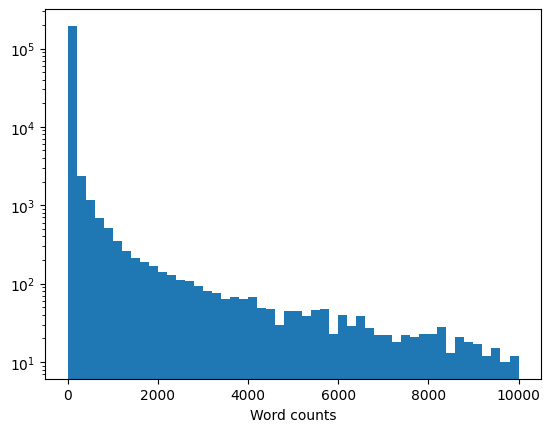

In [12]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [13]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, counts in token_counts.items() if counts >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [14]:

print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [15]:
token_to_id = {token : id for id, token in enumerate(tokens)}


In [16]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


In [17]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])
def as_matrix_with_pad_sequence(sequences, max_len=None):
    """ Convert a list of token sequences into a padded matrix using pad_sequence """
    
    
    if isinstance(sequences[0], str):
        sequences = [seq.split() for seq in sequences]

    
    indexed_sequences = [
        torch.tensor([token_to_id.get(word, UNK_IX) for word in seq], dtype=torch.int32)
        for seq in sequences
    ]

    
    padded_matrix = pad_sequence(indexed_sequences, batch_first=True, padding_value=PAD_IX)

    
    if max_len:
        padded_matrix = padded_matrix[:, :max_len]
    
    return padded_matrix

In [18]:
UNK_IX, PAD_IX 

(0, 1)

In [19]:
print(as_matrix_with_pad_sequence(data['FullDescription'][0:3]).shape)

torch.Size([3, 273])


In [20]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix_with_pad_sequence(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
tensor([[    2,     3,     4,     1,     1],
        [  550,  2380,     1,     1,     1],
        [  320, 10714,   392,   307,    32]], dtype=torch.int32)


In [21]:


# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [22]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [36]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if isinstance(arr, torch.Tensor):
            # Если arr уже тензор, используем clone().detach().to(device)
            batch_tensors[key] = arr.clone().detach().to(device)
        else:
            # Если это не тензор, создаем новый тензор
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64 if key in ["FullDescription", "Title"] else torch.float32)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix_with_pad_sequence(data["Title"].values, max_len).clone().detach().to(device)
    batch["FullDescription"] = as_matrix_with_pad_sequence(data["FullDescription"].values, max_len).clone().detach().to(device)
    batch['Categorical'] = torch.tensor(categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1)), device=device, dtype=torch.float32)
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [24]:
b = make_batch(data_train[:3], max_len=10)

/var/folders/8w/604_tnhn4wj_wpt45zv8h4xr0000gn/T/ipykernel_2547/1519450657.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)


In [25]:

class TextEnc(nn.Module):
    def __init__(self, n_tokens, token_emb_size, out_channels=64):
        super().__init__()
        self.emb = nn.Embedding(n_tokens, token_emb_size)  # Embedding слой
        self.conv = nn.Conv1d(token_emb_size, out_channels, kernel_size=3)  # Свёрточный слой

    def forward(self, idx):
        # Пропускаем индексы через embedding слой
        out = self.emb(idx)
        # Транспонируем, чтобы канал стал первым измерением
        out = out.transpose(2, 1)
        # Пропускаем через свёрточный слой
        out = self.conv(out)
        # Применяем max-pooling по временной оси
        out = torch.max(out, dim=-1).values
        return out


In [26]:
class CategoricalEnc(nn.Module):
    def __init__(self, input_dim, output_dim=64):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

In [31]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens, n_cat_features, hidden_size=64):
        super().__init__()
        self.title_enc = TextEnc(n_tokens, token_emb_size=32, out_channels=hidden_size)
        self.desc_enc = TextEnc(n_tokens, token_emb_size=32, out_channels=hidden_size)

        self.cat_enc =  CategoricalEnc(n_cat_features, output_dim=hidden_size)

        self.fc= nn.Linear(hidden_size * 3, 1)
    
    def forward(self, batch):
        title_features = self.title_enc(batch['Title'])
        desc_features = self.desc_enc(batch['FullDescription'])
        cat_features = self.cat_enc(batch['Categorical'])
        features = torch.cat([title_features, desc_features, cat_features], dim=1)

        output = self.fc(features).squeeze(1)
        return output

In [37]:
BATCH_SIZE = 16
EPOCHS = 5
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break


In [38]:
model = SalaryPredictor(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    for batch in tqdm(iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device), total=len(data_train) // BATCH_SIZE):
        # Прямой проход
        pred = model(batch)
        
        # Вычисление функции потерь
        loss = criterion(pred, batch[TARGET_COLUMN])
        
        # Обратное распространение ошибки и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Печать метрик после каждой эпохи
    print_metrics(model, data_val, device=device)

  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.08930
Mean absolute error: 0.22954


  0%|          | 0/12238 [00:00<?, ?it/s]

KeyboardInterrupt: 